In [1]:
!pip install tensorflow_text 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.6 MB 13.7 MB/s 
     |████████████████████████████████| 511.7 MB 6.9 kB/s 
     |████████████████████████████████| 5.8 MB 53.8 MB/s 
     |████████████████████████████████| 1.6 MB 58.0 MB/s 
     |████████████████████████████████| 438 kB 68.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Unins

In [2]:
import keras
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import EarlyStopping
import numpy as np
import seaborn as sns

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
dataset = 'enron_cleaned'

df = pd.read_csv('/content/drive/MyDrive/NLP/'+dataset+'.csv', index_col=False)

new_model = True
downsample = False 


# check count and unique and top values and their frequency
print(df['label'].value_counts())

# creating 2 new dataframe as df_ham , df_spam
df_spam = df[df['label'] == 1]
df_ham = df[df['label'] == 0]

df_ham_downsampled = df_ham.sample(df_spam.shape[0])


# concating both dataset - df_spam and df_ham_balanced to create df_balanced dataset
df_balanced = pd.concat([df_spam, df_ham_downsampled])


X_train, X_val, y_train, y_val = train_test_split(df['text'], df['label'], train_size=0.7)
if (downsample):
    X_train, X_val, y_train, y_val = train_test_split(df_balanced['text'], df_balanced['label'], train_size=0.7)
    print('data is downsampled')
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, train_size=0.5)


0    15861
1    14175
Name: label, dtype: int64


In [7]:
model = None
if (new_model):

    print('Generating new model')
    bert_preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
    
    bertURL = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2'

    bert_encoder = hub.KerasLayer(bertURL)

    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='Inputs')
    preprocessed_text = bert_preprocessor(text_input)
    embed = bert_encoder(preprocessed_text)
    
    x = tf.keras.layers.Dropout(0.25)(embed['pooled_output'])
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(x)

    # creating final model
    model = tf.keras.Model(inputs=[text_input], outputs=[outputs])

    #model.save("../content/Model")
else:
    print('Loading old model')
    model = keras.models.load_model("../Bert/Model")

# if (model is None):
#     print("Error: No model")
#     return

print(model.summary())

Metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
            ]

# compiling our model
model.compile(optimizer='adam',loss='binary_crossentropy',  metrics=Metrics)

es = EarlyStopping(patience=5, verbose=1, min_delta=0.001, monitor='loss', mode='auto',
                       restore_best_weights=True)

num_epochs = 200
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_val, y_val),batch_size = 50,
                    callbacks=[es],shuffle= True)







Generating new model
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inputs (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 keras_layer_4 (KerasLayer)     {'input_mask': (Non  0           ['Inputs[0][0]']                 
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                           

In [8]:
model.save('/content/drive/MyDrive/NLP/'+dataset)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP/enron_cleaned/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP/enron_cleaned/assets


In [9]:
best_epoch = es.best_epoch

model.evaluate(X_test, y_test)


# getting y_pred by predicting over X_text and flattening it
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()  # require to be in one-dimensional array , for easy manipulation

# y_test = y_test.to_numpy()
y_pred = np.where(y_pred > 0.5, 1, 0)

141/141 [==============================] - 15s 102ms/step


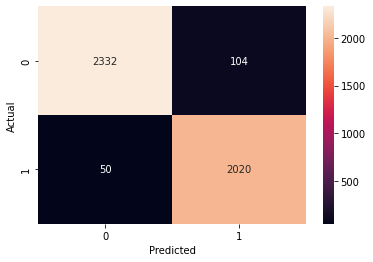

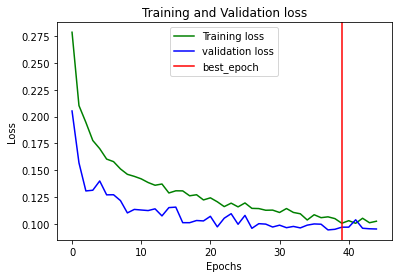

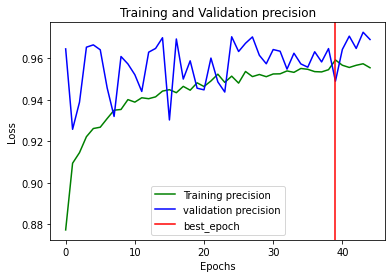

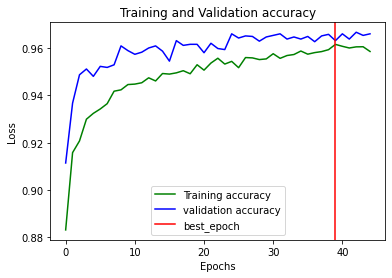

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2436
           1       0.95      0.98      0.96      2070

    accuracy                           0.97      4506
   macro avg       0.97      0.97      0.97      4506
weighted avg       0.97      0.97      0.97      4506

1/1 [==============================] - 0s 415ms/step
[['spam']
 ['ham']
 ['spam']
 ['spam']
 ['ham']
 ['ham']]


In [10]:
# creating confusion matrix

cm = confusion_matrix(y_test, y_pred)


#creating a graph out of confusion matrix
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
# plt.savefig('../Bert/Data/bert_CM.png')
plt.savefig('/content/drive/MyDrive/NLP/Bert_'+dataset+'/figures/bert'+dataset+'_CM.png')
plt.show()

#epochs = range(1, num_epochs+1)
#print(epochs)
plt.plot(history.history['loss'], 'g', label='Training loss')
plt.plot(history.history['val_loss'], 'b', label='validation loss')
plt.axvline(x=best_epoch, color='r', label='best_epoch')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/NLP/Bert_'+dataset+'/figures/bert'+dataset+'_loss.png')
plt.show()



#epochs = range(1, num_epochs+1)
plt.plot(history.history['precision'], 'g', label='Training precision')
plt.plot(history.history['val_precision'], 'b', label='validation precision')
plt.axvline(x=best_epoch, color='r', label='best_epoch')
plt.title('Training and Validation precision')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/NLP/Bert_'+dataset+'/figures/bert'+dataset+'_precision.png')
# plt.savefig('../Bert/Data/bert_precision.png')
plt.show()


plt.plot( history.history['accuracy'], 'g', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'b', label='validation accuracy')
plt.axvline(x=best_epoch, color='r', label='best_epoch')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/NLP/Bert_'+dataset+'/figures/bert'+dataset+'_accuracy.png')
# plt.savefig('../Bert/Data/bert_accuracy.png')
plt.show()

# printing classification report
print(classification_report(y_test, y_pred))

predict_text = [
    # Spam
    'We’d all like to get a $10,000 deposit on our bank accounts out of the blue, but winning a prize—especially if you’ve never entered a contest',
    'Netflix is sending you a refund of $12.99. Please reply with your bank account and routing number to verify and get your refund',
    'Your account is temporarily frozen. Please log in to to secure your account ',
    # ham
    'The article was published on 18th August itself',
    'Although we are unable to give you an exact time-frame at the moment, I would request you to stay tuned for any updates.',
    'The image you sent is a UI bug, I can check that your article is marked as regular and is not in the monetization program.'
]
test_results = model.predict(predict_text)
output = np.where(test_results > 0.5, 'spam', 'ham')
print(output)